In [119]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np

def summary_with_rf(model, input_size, batch_size=-1, device="cuda", dtypes=None, debug=False):
    """
    Enhanced torchsummary that calculates and displays receptive fields
    
    Args:
        model: PyTorch model
        input_size: Input tensor size (C, H, W) or tuple of sizes for multiple inputs
        batch_size: Batch size for summary (default: -1)
        device: Device to run model on (default: "cuda")
        dtypes: Data types for inputs (default: None, uses torch.FloatTensor)
        debug: If True, prints detailed RF calculations (Nin, Nout, k, s, p, Jin, Jout, Rin, Rout)
        
    Returns:
        None (prints summary table)
    """
    
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)
            
            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size
                
            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params
            
            # Calculate receptive field
            rf_info = calculate_rf_for_layer(module, m_key)
            summary[m_key]["receptive_field"] = rf_info

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    # Initialize RF tracking
    current_rf = 1
    current_jump = 1
    current_size = input_size[1] if isinstance(input_size, (tuple, list)) and len(input_size) > 1 else input_size[0] if isinstance(input_size, (tuple, list)) else 28
    original_input_size = current_size  # Keep track of original input size

    def calculate_rf_for_layer(module, layer_name):
        nonlocal current_rf, current_jump, current_size
        
        if isinstance(module, nn.Conv2d):
            kernel_size = module.kernel_size[0] if isinstance(module.kernel_size, tuple) else module.kernel_size
            stride = module.stride[0] if isinstance(module.stride, tuple) else module.stride
            padding = module.padding[0] if isinstance(module.padding, tuple) else module.padding
            
            # Store old values for debug
            old_size = current_size
            old_rf = current_rf
            old_jump = current_jump
            
            # Calculate output size: Nout = 1 + (Nin + 2*p - k)/s
            new_size = 1 + (current_size + 2 * padding - kernel_size) // stride
            
            # Calculate new RF: RFout = RFin + (k-1) * Jin
            new_rf = current_rf + (kernel_size - 1) * current_jump
            
            # Calculate new Jump: Jout = s * Jin
            new_jump = stride * current_jump
            
            if debug:
                print(f"\n[DEBUG] {layer_name} (Conv2d):")
                print(f"  Nin={old_size}, Nout={new_size}, k={kernel_size}, s={stride}, p={padding}")
                print(f"  Jin={old_jump}, Jout={new_jump}")
                print(f"  Rin={old_rf}, Rout={new_rf}")
                print(f"  Formula: Nout = 1 + ({old_size} + 2*{padding} - {kernel_size})/{stride} = {new_size}")
                print(f"  Formula: Rout = {old_rf} + ({kernel_size}-1)*{old_jump} = {new_rf}")
                print(f"  Formula: Jout = {stride}*{old_jump} = {new_jump}")
            
            current_size = new_size
            current_rf = new_rf
            current_jump = new_jump
            
            return new_rf
            
        elif isinstance(module, nn.MaxPool2d):
            kernel_size = module.kernel_size
            stride = module.stride if module.stride is not None else kernel_size
            padding = module.padding
            
            # Store old values for debug
            old_size = current_size
            old_rf = current_rf
            old_jump = current_jump
            
            # Calculate output size: Nout = 1 + (Nin + 2*p - k)/s
            new_size = 1 + (current_size + 2 * padding - kernel_size) // stride
            
            # Calculate new RF: RFout = RFin + (k-1) * Jin
            new_rf = current_rf + (kernel_size - 1) * current_jump
            
            # Calculate new Jump: Jout = s * Jin
            new_jump = stride * current_jump
            
            if debug:
                print(f"\n[DEBUG] {layer_name} (MaxPool2d):")
                print(f"  Nin={old_size}, Nout={new_size}, k={kernel_size}, s={stride}, p={padding}")
                print(f"  Jin={old_jump}, Jout={new_jump}")
                print(f"  Rin={old_rf}, Rout={new_rf}")
                print(f"  Formula: Nout = 1 + ({old_size} + 2*{padding} - {kernel_size})/{stride} = {new_size}")
                print(f"  Formula: Rout = {old_rf} + ({kernel_size}-1)*{old_jump} = {new_rf}")
                print(f"  Formula: Jout = {stride}*{old_jump} = {new_jump}")
            
            current_size = new_size
            current_rf = new_rf
            current_jump = new_jump
            
            return new_rf
            
        elif isinstance(module, nn.AdaptiveAvgPool2d):
            # FIXED: Properly handle AdaptiveAvgPool2d
            output_size = module.output_size
            
            # Store old values for debug
            old_size = current_size
            old_rf = current_rf
            old_jump = current_jump
            
            # Check if it's global pooling (output size is 1x1)
            if (isinstance(output_size, int) and output_size == 1) or \
               (isinstance(output_size, (tuple, list)) and output_size[0] == 1 and output_size[1] == 1):
                # Global Average Pooling - RF becomes the entire feature map
                # The RF now covers the entire spatial dimension
                global_rf = f"GLOBAL({current_size}x{current_size})"
                
                if debug:
                    print(f"\n[DEBUG] {layer_name} (AdaptiveAvgPool2d - Global):")
                    print(f"  Nin={old_size}, Nout=1, k={old_size} (adaptive), s={old_size}, p=0")
                    print(f"  Jin={old_jump}, Jout=1 (global pooling)")
                    print(f"  Rin={old_rf}, Rout=GLOBAL({old_size}x{old_size})")
                    print(f"  Note: Global Average Pooling - each output sees entire {old_size}x{old_size} feature map")
                    print(f"  Effective RF in original input space: {original_input_size}x{original_input_size}")
                
                current_size = 1
                # For subsequent layers, we'll track that RF is global
                current_rf = original_input_size  # Use original input size as effective RF
                current_jump = 1  # Jump doesn't matter after global pooling
                return global_rf
            else:
                # For other adaptive pool sizes, calculate approximate RF
                # This is a simplification - actual RF depends on input/output ratio
                if isinstance(output_size, int):
                    out_h = out_w = output_size
                else:
                    out_h, out_w = output_size
                
                # Approximate kernel size based on input/output ratio
                approx_kernel_h = current_size // out_h
                approx_kernel_w = current_size // out_w
                approx_kernel = max(approx_kernel_h, approx_kernel_w)
                
                # Update RF based on approximate kernel
                new_rf = current_rf + (approx_kernel - 1) * current_jump
                
                if debug:
                    print(f"\n[DEBUG] {layer_name} (AdaptiveAvgPool2d):")
                    print(f"  Nin={old_size}, Nout={out_h}, k≈{approx_kernel} (adaptive), s≈{approx_kernel}, p=0")
                    print(f"  Jin={old_jump}, Jout={old_jump}")
                    print(f"  Rin={old_rf}, Rout={new_rf}")
                    print(f"  Note: Non-global adaptive pooling to {out_h}x{out_w}")
                
                current_size = out_h  # Assuming square output
                current_rf = new_rf
                
                return new_rf
                
        elif isinstance(module, (nn.BatchNorm2d, nn.Dropout, nn.ReLU)):
            # These layers don't change receptive field
            if debug:
                print(f"\n[DEBUG] {layer_name} ({module.__class__.__name__}):")
                print(f"  No change in RF: Nin={current_size}, Nout={current_size}")
                print(f"  Jin={current_jump}, Jout={current_jump}")
                print(f"  Rin={current_rf}, Rout={current_rf}")
            return current_rf
            
        elif isinstance(module, nn.Linear):
            # Linear layers typically come after flattening, RF stays the same
            if debug:
                print(f"\n[DEBUG] {layer_name} (Linear):")
                print(f"  After flattening - RF stays at {current_rf}")
            return current_rf
            
        else:
            # For unknown layers, assume RF doesn't change
            if debug:
                print(f"\n[DEBUG] {layer_name} ({module.__class__.__name__}):")
                print(f"  Unknown layer type - RF unchanged at {current_rf}")
            return current_rf

    # Check device
    device = device.type
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # Multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]
    if isinstance(input_size[0], (list, tuple)):
        input_size = input_size
    else:
        input_size = [input_size]

    # Batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]

    # Create properties
    summary = OrderedDict()
    hooks = []

    # Register hook
    model.apply(register_hook)

    # Make a forward pass
    model(*x)

    # Remove these hooks
    for h in hooks:
        h.remove()

    # Print summary
    if debug:
        print("\n" + "=" * 80)
        print("DEBUG MODE: Detailed RF Calculations Complete")
        print("=" * 80 + "\n")
    
    print("=" * 80)
    line_new = "{:>25}  {:>25} {:>15} {:>15}".format(
        "Layer (type)", "Output Shape", "Param #", "RF"
    )
    print(line_new)
    print("=" * 80)
    
    total_params = 0
    total_output = 0
    trainable_params = 0
    
    for layer in summary:
        # Input_shape, output_shape, trainable, nb_params
        rf_display = str(summary[layer]["receptive_field"])
        line_new = "{:>25}  {:>25} {:>15} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
            rf_display,
        )
        total_params += summary[layer]["nb_params"]

        total_output_size = abs(np.prod(summary[layer]["output_shape"]))
        total_output += total_output_size

        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        print(line_new)

    # Assume 4 bytes/number (float on cuda).
    total_input_size = abs(np.prod(sum(input_size, ())))
    total_output_size = abs(2.0 * total_output * 4.0 / (1024 ** 2.0))  # x2 for gradients
    total_params_size = abs(total_params * 4.0 / (1024 ** 2.0))
    total_input_size = abs(total_input_size * 4.0 / (1024 ** 2.0))

    print("=" * 80)
    print("Total params: {0:,}".format(total_params))
    print("Trainable params: {0:,}".format(trainable_params))
    print("Non-trainable params: {0:,}".format(total_params - trainable_params))
    print("-" * 80)
    print("Input size (MB): %0.2f" % total_input_size)
    print("Forward/backward pass size (MB): %0.2f" % total_output_size)
    print("Params size (MB): %0.2f" % total_params_size)
    print("Estimated Total Size (MB): %0.2f" % (total_params_size + total_output_size + total_input_size))
    print("=" * 80)
    # Display final RF
    final_rf_display = f"GLOBAL({original_input_size}x{original_input_size})" if isinstance(current_rf, int) and current_rf >= original_input_size else str(current_rf)
    print(f"Final Receptive Field: {final_rf_display}")
    print("=" * 80)


# Helper function to calculate RF for functional operations
def calculate_functional_rf(operation_name, current_rf, current_jump, current_size, **kwargs):
    """
    Calculate RF for functional operations like F.max_pool2d, F.conv2d, etc.
    
    Args:
        operation_name: Name of the operation ('max_pool2d', 'conv2d', etc.)
        current_rf: Current receptive field
        current_jump: Current jump
        current_size: Current spatial size
        **kwargs: Operation-specific parameters
        
    Returns:
        tuple: (new_rf, new_jump, new_size)
    """
    
    if operation_name == 'max_pool2d':
        kernel_size = kwargs.get('kernel_size', 2)
        stride = kwargs.get('stride', kernel_size)
        padding = kwargs.get('padding', 0)
        
        # Calculate output size: Nout = 1 + (Nin + 2*p - k)/s
        new_size = 1 + (current_size + 2 * padding - kernel_size) // stride
        
        # Calculate new RF: RFout = RFin + (k-1) * Jin
        new_rf = current_rf + (kernel_size - 1) * current_jump
        
        # Calculate new Jump: Jout = s * Jin
        new_jump = stride * current_jump
        
        return new_rf, new_jump, new_size
        
    elif operation_name == 'avg_pool2d':
        # Same calculation as max_pool2d
        return calculate_functional_rf('max_pool2d', current_rf, current_jump, current_size, **kwargs)
        
    elif operation_name == 'adaptive_avg_pool2d':
        # FIXED: Handle adaptive pooling
        output_size = kwargs.get('output_size', 1)
        
        if output_size == 1 or output_size == (1, 1):
            # Global pooling - RF becomes the entire feature map
            return 'GLOBAL', 1, 1
        else:
            # For other sizes, approximate
            if isinstance(output_size, int):
                out_size = output_size
            else:
                out_size = output_size[0]  # Assuming square
            
            approx_kernel = current_size // out_size
            new_rf = current_rf + (approx_kernel - 1) * current_jump
            return new_rf, current_jump, out_size
        
    elif operation_name in ['relu', 'dropout']:
        # These don't change RF
        return current_rf, current_jump, current_size
        
    else:
        # Unknown operation, assume no change
        return current_rf, current_jump, current_size



In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import traceback

class ModelShapeDebugger:
    """
    A debugging tool to trace tensor shapes through a PyTorch model's forward pass
    and identify size mismatches.
    """
    
    def __init__(self, model, input_shape=(1, 1, 28, 28), device='cpu'):
        """
        Initialize the debugger.
        
        Args:
            model: PyTorch model to debug
            input_shape: Input tensor shape (batch_size, channels, height, width)
            device: Device to run the model on
        """
        self.model = model.to(device)
        self.input_shape = input_shape
        self.device = device
        self.layer_outputs = OrderedDict()
        self.hooks = []
        
    def hook_fn(self, name):
        """Create a hook function to capture layer outputs."""
        def hook(module, input, output):
            # Store input and output shapes
            input_shapes = []
            if isinstance(input, tuple):
                for inp in input:
                    if isinstance(inp, torch.Tensor):
                        input_shapes.append(list(inp.shape))
            else:
                input_shapes.append(list(input.shape))
            
            output_shape = list(output.shape) if isinstance(output, torch.Tensor) else str(output)
            
            self.layer_outputs[name] = {
                'module': module.__class__.__name__,
                'input_shapes': input_shapes,
                'output_shape': output_shape,
                'module_repr': str(module)
            }
        return hook
    
    def register_hooks(self):
        """Register forward hooks on all layers."""
        for name, module in self.model.named_modules():
            if len(list(module.children())) == 0:  # Only hook leaf modules
                hook = module.register_forward_hook(self.hook_fn(name))
                self.hooks.append(hook)
    
    def remove_hooks(self):
        """Remove all registered hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def trace_forward_pass(self):
        """
        Trace the forward pass and capture shapes at each layer.
        Returns True if successful, False if error encountered.
        """
        self.layer_outputs.clear()
        self.register_hooks()
        
        # Create dummy input
        x = torch.randn(*self.input_shape).to(self.device)
        
        try:
            # Run forward pass
            with torch.no_grad():
                output = self.model(x)
            
            self.remove_hooks()
            return True, None
            
        except Exception as e:
            self.remove_hooks()
            return False, e
    
    def analyze_model(self):
        """
        Analyze the model and print layer-by-layer shape information.
        Identifies the first size mismatch if any.
        """
        print("="*80)
        print("MODEL SHAPE ANALYSIS")
        print("="*80)
        print(f"Input Shape: {self.input_shape}")
        print("-"*80)
        
        success, error = self.trace_forward_pass()
        
        if success:
            self._print_successful_trace()
        else:
            self._print_error_trace(error)
    
    def _print_successful_trace(self):
        """Print the successful trace of all layers."""
        print("\n✓ Forward pass completed successfully!\n")
        print("Layer-by-Layer Shape Trace:")
        print("-"*80)
        
        for i, (name, info) in enumerate(self.layer_outputs.items(), 1):
            if name:  # Skip empty names
                print(f"\n[{i}] Layer: {name}")
                print(f"    Type: {info['module']}")
                print(f"    Input Shape(s): {info['input_shapes']}")
                print(f"    Output Shape: {info['output_shape']}")
                if 'Conv2d' in info['module'] or 'Linear' in info['module']:
                    print(f"    Layer Config: {info['module_repr']}")
    
    def _print_error_trace(self, error):
        """Print the trace up to the error point."""
        print("\n✗ ERROR DETECTED!\n")
        print("Successful layers before error:")
        print("-"*80)
        
        for i, (name, info) in enumerate(self.layer_outputs.items(), 1):
            if name:
                print(f"\n[{i}] Layer: {name}")
                print(f"    Type: {info['module']}")
                print(f"    Input Shape(s): {info['input_shapes']}")
                print(f"    Output Shape: {info['output_shape']}")
                if 'Conv2d' in info['module'] or 'Linear' in info['module']:
                    print(f"    Layer Config: {info['module_repr']}")
        
        print("\n" + "="*80)
        print("ERROR DETAILS:")
        print("="*80)
        print(f"Error Type: {type(error).__name__}")
        print(f"Error Message: {str(error)}")
        
        # Try to identify the problematic layer
        self._identify_problematic_layer(error)
    
    def _identify_problematic_layer(self, error):
        """Try to identify which layer caused the error."""
        error_msg = str(error)
        
        print("\n" + "-"*80)
        print("DIAGNOSIS:")
        print("-"*80)
        
        if "size mismatch" in error_msg.lower() or "shape" in error_msg.lower():
            print("✗ Tensor size mismatch detected!")
            
            # Parse error message for size information
            import re
            numbers = re.findall(r'\d+', error_msg)
            if numbers:
                print(f"Conflicting dimensions found in error: {numbers}")
            
            # Check the last successful layer
            if self.layer_outputs:
                last_layer = list(self.layer_outputs.items())[-1]
                print(f"\nLast successful layer: {last_layer[0]}")
                print(f"Last output shape: {last_layer[1]['output_shape']}")
                print("\nThe error likely occurs in the NEXT layer after this one.")
        
        elif "expected" in error_msg.lower() and "got" in error_msg.lower():
            print("✗ Input channel mismatch detected!")
            print("The layer expects a different number of input channels than provided.")
        
        print("\nRecommendation: Check the layer definition that comes after the last")
        print("successful layer in your forward() method.")


def debug_model_shapes(model_class, input_shape=(1, 1, 28, 28), device='cpu'):
    """
    Convenience function to debug a model class.
    
    Args:
        model_class: The model class (not instance) to debug
        input_shape: Input tensor shape
        device: Device to run on
    
    Returns:
        ModelShapeDebugger instance
    """
    try:
        model = model_class()
    except Exception as e:
        print(f"Error instantiating model: {e}")
        return None
    
    debugger = ModelShapeDebugger(model, input_shape, device)
    debugger.analyze_model()
    return debugger


 

In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Dict
from dataclasses import dataclass
import random


@dataclass
class FailureCase:
    """Data class to store information about a failure case"""
    image: torch.Tensor
    true_label: int
    predicted_label: int
    confidence: float
    loss: float
    batch_idx: int
    sample_idx: int


class FailureAnalyzer:
    """
    Class to analyze and visualize model failure cases during testing.
    
    This class captures misclassified samples during model evaluation and provides
    methods to visualize them along with their predictions and ground truth labels.
    """
    
    def __init__(self, class_names: Optional[List[str]] = None, max_failures: int = 1000):
        """
        Initialize the FailureAnalyzer.
        
        Args:
            class_names: Optional list of class names for better visualization
            max_failures: Maximum number of failures to store (to manage memory)
        """
        self.failures = []
        self.class_names = class_names
        self.max_failures = max_failures
        self.total_samples = 0
        self.total_failures = 0
        
        # Store confusion matrix data
        self.confusion_pairs = {}  # (true_label, pred_label): count
        
    def reset(self):
        """Reset all stored failures and statistics"""
        self.failures = []
        self.total_samples = 0
        self.total_failures = 0
        self.confusion_pairs = {}
    
    def add_batch(self, images: torch.Tensor, targets: torch.Tensor, 
                  outputs: torch.Tensor, batch_idx: int = 0):
        """
        Process a batch of predictions and store failure cases.
        
        Args:
            images: Input images tensor (batch_size, channels, height, width)
            targets: True labels tensor (batch_size,)
            outputs: Model outputs/logits tensor (batch_size, num_classes)
            batch_idx: Index of the current batch
        """
        # Get predictions
        probs = F.softmax(outputs, dim=1)
        confidences, predictions = torch.max(probs, dim=1)
        
        # Calculate losses for each sample
        losses = F.cross_entropy(outputs, targets, reduction='none')
        
        # Find misclassified samples
        incorrect_mask = predictions != targets
        incorrect_indices = torch.where(incorrect_mask)[0]
        
        # Update statistics
        self.total_samples += len(targets)
        self.total_failures += len(incorrect_indices)
        
        # Store failure cases
        for idx in incorrect_indices:
            if len(self.failures) < self.max_failures:
                # Update confusion matrix data
                true_label = targets[idx].item()
                pred_label = predictions[idx].item()
                pair = (true_label, pred_label)
                self.confusion_pairs[pair] = self.confusion_pairs.get(pair, 0) + 1
                
                # Create failure case
                failure = FailureCase(
                    image=images[idx].cpu().detach(),
                    true_label=true_label,
                    predicted_label=pred_label,
                    confidence=confidences[idx].item(),
                    loss=losses[idx].item(),
                    batch_idx=batch_idx,
                    sample_idx=idx.item()
                )
                self.failures.append(failure)
    
    def get_failure_rate(self) -> float:
        """Get the overall failure rate"""
        if self.total_samples == 0:
            return 0.0
        return (self.total_failures / self.total_samples) * 100
    
    def get_most_confused_pairs(self, top_k: int = 5) -> List[Tuple]:
        """
        Get the most common confusion pairs.
        
        Args:
            top_k: Number of top confusion pairs to return
            
        Returns:
            List of ((true_label, predicted_label), count) tuples
        """
        sorted_pairs = sorted(self.confusion_pairs.items(), 
                            key=lambda x: x[1], reverse=True)
        return sorted_pairs[:top_k]
    
    def show_failures(self, num_samples: int = 10, 
                     sort_by: str = 'loss',
                     figsize: Tuple[int, int] = (15, 10),
                     save_path: Optional[str] = None):
        """
        Display failure cases in a grid.
        
        Args:
            num_samples: Number of failure cases to display
            sort_by: How to sort failures ('loss', 'confidence', 'random')
            figsize: Figure size for the plot
            save_path: Optional path to save the figure
        """
        if not self.failures:
            print("No failure cases to display!")
            return
        
        # Sort failures based on criteria
        if sort_by == 'loss':
            sorted_failures = sorted(self.failures, key=lambda x: x.loss, reverse=True)
        elif sort_by == 'confidence':
            sorted_failures = sorted(self.failures, key=lambda x: x.confidence, reverse=True)
        else:  # random
            sorted_failures = random.sample(self.failures, 
                                          min(num_samples, len(self.failures)))
        
        # Limit to requested number
        failures_to_show = sorted_failures[:min(num_samples, len(sorted_failures))]
        
        # Calculate grid dimensions
        n_samples = len(failures_to_show)
        n_cols = min(5, n_samples)
        n_rows = (n_samples + n_cols - 1) // n_cols
        
        # Create figure
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        fig.suptitle(f'Model Failure Cases (sorted by {sort_by})', fontsize=16, fontweight='bold')
        
        for idx, failure in enumerate(failures_to_show):
            row = idx // n_cols
            col = idx % n_cols
            ax = axes[row, col]
            
            # Prepare image for display
            img = failure.image
            if img.dim() == 3:  # (C, H, W)
                if img.shape[0] == 1:  # Grayscale
                    img = img.squeeze(0)
                    cmap = 'gray'
                else:  # RGB
                    img = img.permute(1, 2, 0)
                    cmap = None
            else:  # Already 2D
                cmap = 'gray'
            
            # Display image
            ax.imshow(img, cmap=cmap)
            
            # Format labels
            true_label = self._format_label(failure.true_label)
            pred_label = self._format_label(failure.predicted_label)
            
            # Set title with color coding (red for wrong, green for correct)
            title = f'True: {true_label}\nPred: {pred_label}\n'
            title += f'Conf: {failure.confidence:.2%}\nLoss: {failure.loss:.3f}'
            
            ax.set_title(title, fontsize=10, color='red')
            ax.axis('off')
        
        # Hide empty subplots
        for idx in range(n_samples, n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            axes[row, col].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=100, bbox_inches='tight')
            print(f"Figure saved to {save_path}")
        
        plt.show()
    
    def show_confusion_analysis(self, top_k: int = 10, 
                               figsize: Tuple[int, int] = (12, 6)):
        """
        Show analysis of most confused class pairs.
        
        Args:
            top_k: Number of top confusion pairs to show
            figsize: Figure size for the plot
        """
        if not self.confusion_pairs:
            print("No confusion data available!")
            return
        
        # Get top confused pairs
        top_pairs = self.get_most_confused_pairs(top_k)
        
        # Create bar plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Plot 1: Bar chart of confusion pairs
        labels = []
        counts = []
        for (true_label, pred_label), count in top_pairs:
            true_str = self._format_label(true_label)
            pred_str = self._format_label(pred_label)
            labels.append(f'{true_str}→{pred_str}')
            counts.append(count)
        
        ax1.barh(range(len(labels)), counts, color='coral')
        ax1.set_yticks(range(len(labels)))
        ax1.set_yticklabels(labels)
        ax1.set_xlabel('Number of Misclassifications')
        ax1.set_title(f'Top {len(labels)} Confusion Pairs')
        ax1.invert_yaxis()
        
        # Add value labels on bars
        for i, count in enumerate(counts):
            ax1.text(count, i, f' {count}', va='center')
        
        # Plot 2: Failure rate and statistics
        stats_text = f"""
        Total Samples: {self.total_samples:,}
        Total Failures: {self.total_failures:,}
        Failure Rate: {self.get_failure_rate():.2f}%
        Unique Confusion Pairs: {len(self.confusion_pairs)}
        Failures Captured: {len(self.failures)}
        """
        
        ax2.text(0.1, 0.5, stats_text, fontsize=12, 
                verticalalignment='center', fontfamily='monospace')
        ax2.set_title('Summary Statistics')
        ax2.axis('off')
        
        plt.suptitle('Failure Analysis Summary', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def show_worst_failures(self, num_samples: int = 5, 
                           figsize: Tuple[int, int] = (15, 3)):
        """
        Show the worst failure cases (highest loss).
        
        Args:
            num_samples: Number of worst cases to show
            figsize: Figure size for the plot
        """
        self.show_failures(num_samples=num_samples, sort_by='loss', figsize=figsize)
    
    def show_high_confidence_failures(self, num_samples: int = 5,
                                     figsize: Tuple[int, int] = (15, 3)):
        """
        Show failure cases where the model was highly confident but wrong.
        
        Args:
            num_samples: Number of cases to show
            figsize: Figure size for the plot
        """
        self.show_failures(num_samples=num_samples, sort_by='confidence', figsize=figsize)
    
    def _format_label(self, label: int) -> str:
        """Format label with class name if available"""
        if self.class_names and label < len(self.class_names):
            return f'{self.class_names[label]}'
        return str(label)
    
    def get_failure_summary(self) -> Dict:
        """
        Get a summary dictionary of failure statistics.
        
        Returns:
            Dictionary containing various failure statistics
        """
        if not self.failures:
            return {
                'total_samples': self.total_samples,
                'total_failures': 0,
                'failure_rate': 0.0,
                'avg_loss': 0.0,
                'avg_confidence': 0.0
            }
        
        avg_loss = np.mean([f.loss for f in self.failures])
        avg_confidence = np.mean([f.confidence for f in self.failures])
        
        return {
            'total_samples': self.total_samples,
            'total_failures': self.total_failures,
            'failure_rate': self.get_failure_rate(),
            'failures_captured': len(self.failures),
            'avg_loss': avg_loss,
            'avg_confidence': avg_confidence,
            'unique_confusion_pairs': len(self.confusion_pairs),
            'top_confusions': self.get_most_confused_pairs(5)
        }

In [135]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.relu = nn.ReLU(inplace=False)

        d_val = 0.1

        self.conv0 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.bn0 = nn.BatchNorm2d(4)
        self.dropout0 = nn.Dropout(d_val * 1.5 )

        self.conv1 = nn.Conv2d(4, 8, kernel_size=3, padding = 1)   
        self.bn1 = nn.BatchNorm2d(8)
        self.dropout1 = nn.Dropout(d_val * 1.25)

        self.maxpool1 = nn.MaxPool2d (kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding = 1)
        self.bn2 = nn.BatchNorm2d(16)
        self.dropout2 = nn.Dropout(d_val )

        self.conv3 = nn.Conv2d(16, 22, kernel_size=3, padding = 1)
        self.bn3 = nn.BatchNorm2d(22)
        self.dropout3 = nn.Dropout(d_val )

        self.maxpool2 = nn.MaxPool2d (kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(22, 30, kernel_size=3)
        self.bn_conv4 = nn.BatchNorm2d(30)
        self.dropout_conv4 = nn.Dropout(d_val  )

        self.conv5 = nn.Conv2d(30, 30, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(30)
        self.dropout5 = nn.Dropout(d_val  )

        self.maxpool3 = nn.MaxPool2d (kernel_size=2, stride=2, padding=1)

        self.conv1x1_reduce_1 = nn.Conv2d(30, 10, kernel_size=1) # input -5, RFin=12, s=1  OUtput = 1+(5 + 2*0 - 1)/1 = 5, Jin=4, Jout=1*2=2 RFout=12+(1-1)*2=12
        self.bn_conv1x1_reduce_1 = nn.BatchNorm2d(10)
        self.dropout_conv1x1_reduce_1 = nn.Dropout(d_val  )

        self.gap = nn.AdaptiveAvgPool2d ((1,1))
        self.dropout = nn.Dropout(d_val)
        
        self.classifier = nn.Conv2d(8, 10, kernel_size=1)
        

    def forward(self, x):

      x = self.relu(self.bn0(self.conv0(x)))
      x = self.dropout0(x)

      x = self.relu(self.bn1(self.maxpool1(self.conv1(x))))
      x = self.dropout1(x)
      
      x = self.relu(self.bn2(self.conv2(x))) # 12x12x32
      x = self.dropout2(x)
      
      x = self.relu(self.bn3(self.maxpool2(self.conv3(x)))) # 5x5x32
      #x = self.dropout3(x)
      
      x = self.relu(self.bn_conv4(self.conv4(x)))
      #x = self.dropout_conv4(x)

      x = self.relu(self.bn5(self.maxpool3(self.conv5(x)))) # 5x5x32
      #x = self.dropout5(x)

      x = self.relu(self.bn_conv1x1_reduce_1(self.conv1x1_reduce_1(x)))
      #x = self.dropout_conv1x1_reduce_1(x)

      #x = self.relu(self.bn_conv1x1_reduce_2(self.conv1x1_reduce_2(x)))
      #x = self.dropout_conv1x1_reduce_2(x)

      #x = self.relu(self.bn4(self.conv4(x)))

      x = self.gap(x)  # [B, C, 1, 1]
      x = self.dropout(x)

      # 1x1 conv → 10 channels
      #x = self.classifier(x)                 # [B, 10, 1, 1]

      # Flatten to [B, 10]
      x = torch.flatten(x, 1)
      #x = self.fc3(x)
   
      return F.log_softmax(x, dim=1)

In [124]:
# Method 1: Automatic debugging
print("METHOD 1: Automatic Shape Debugging")
print("="*80)
debugger = debug_model_shapes(Net, input_shape=(1, 1, 28, 28))

print("\n\n")

METHOD 1: Automatic Shape Debugging
MODEL SHAPE ANALYSIS
Input Shape: (1, 1, 28, 28)
--------------------------------------------------------------------------------

✓ Forward pass completed successfully!

Layer-by-Layer Shape Trace:
--------------------------------------------------------------------------------

[1] Layer: conv0
    Type: Conv2d
    Input Shape(s): [[1, 1, 28, 28]]
    Output Shape: [1, 4, 28, 28]
    Layer Config: Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

[2] Layer: bn0
    Type: BatchNorm2d
    Input Shape(s): [[1, 4, 28, 28]]
    Output Shape: [1, 4, 28, 28]

[3] Layer: relu
    Type: ReLU
    Input Shape(s): [[1, 10, 2, 2]]
    Output Shape: [1, 10, 2, 2]

[4] Layer: dropout0
    Type: Dropout
    Input Shape(s): [[1, 4, 28, 28]]
    Output Shape: [1, 4, 28, 28]

[5] Layer: conv1
    Type: Conv2d
    Input Shape(s): [[1, 4, 28, 28]]
    Output Shape: [1, 8, 28, 28]
    Layer Config: Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(

In [125]:
    debugger = ModelShapeDebugger(Net(), input_shape=(1, 1, 28, 28))
    debugger.analyze_model()

MODEL SHAPE ANALYSIS
Input Shape: (1, 1, 28, 28)
--------------------------------------------------------------------------------

✓ Forward pass completed successfully!

Layer-by-Layer Shape Trace:
--------------------------------------------------------------------------------

[1] Layer: conv0
    Type: Conv2d
    Input Shape(s): [[1, 1, 28, 28]]
    Output Shape: [1, 4, 28, 28]
    Layer Config: Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

[2] Layer: bn0
    Type: BatchNorm2d
    Input Shape(s): [[1, 4, 28, 28]]
    Output Shape: [1, 4, 28, 28]

[3] Layer: relu
    Type: ReLU
    Input Shape(s): [[1, 10, 2, 2]]
    Output Shape: [1, 10, 2, 2]

[4] Layer: dropout0
    Type: Dropout
    Input Shape(s): [[1, 4, 28, 28]]
    Output Shape: [1, 4, 28, 28]

[5] Layer: conv1
    Type: Conv2d
    Input Shape(s): [[1, 4, 28, 28]]
    Output Shape: [1, 8, 28, 28]
    Layer Config: Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

[6] Layer: maxpool1
    Type

In [126]:
!pip install torchsummary




[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [127]:
device = torch.device("cpu")
model = Net().to(device)
try:
    dummy_input = torch.randn(1, 1, 28, 28)
    output = model(dummy_input)
    print("Model works on CPU!")
except Exception as e:
    print(f"Error on CPU: {e}")

Model works on CPU!


In [128]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
       BatchNorm2d-2            [-1, 4, 28, 28]               8
              ReLU-3            [-1, 4, 28, 28]               0
           Dropout-4            [-1, 4, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             296
         MaxPool2d-6            [-1, 8, 14, 14]               0
       BatchNorm2d-7            [-1, 8, 14, 14]              16
              ReLU-8            [-1, 8, 14, 14]               0
           Dropout-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           1,168
      BatchNorm2d-11           [-1, 16, 14, 14]              32
             ReLU-12           [-1, 16, 14, 14]               0
          Dropout-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 22,

In [129]:
print("\n" + "="*50)
print("Enhanced Summary with Receptive Field:")
print("="*50)
summary_with_rf(model, input_size=(1, 28, 28), device=device, debug=True)


Enhanced Summary with Receptive Field:

[DEBUG] Conv2d-1 (Conv2d):
  Nin=28, Nout=28, k=3, s=1, p=1
  Jin=1, Jout=1
  Rin=1, Rout=3
  Formula: Nout = 1 + (28 + 2*1 - 3)/1 = 28
  Formula: Rout = 1 + (3-1)*1 = 3
  Formula: Jout = 1*1 = 1

[DEBUG] BatchNorm2d-2 (BatchNorm2d):
  No change in RF: Nin=28, Nout=28
  Jin=1, Jout=1
  Rin=3, Rout=3

[DEBUG] ReLU-3 (ReLU):
  No change in RF: Nin=28, Nout=28
  Jin=1, Jout=1
  Rin=3, Rout=3

[DEBUG] Dropout-4 (Dropout):
  No change in RF: Nin=28, Nout=28
  Jin=1, Jout=1
  Rin=3, Rout=3

[DEBUG] Conv2d-5 (Conv2d):
  Nin=28, Nout=28, k=3, s=1, p=1
  Jin=1, Jout=1
  Rin=3, Rout=5
  Formula: Nout = 1 + (28 + 2*1 - 3)/1 = 28
  Formula: Rout = 3 + (3-1)*1 = 5
  Formula: Jout = 1*1 = 1

[DEBUG] MaxPool2d-6 (MaxPool2d):
  Nin=28, Nout=14, k=2, s=2, p=0
  Jin=1, Jout=2
  Rin=5, Rout=6
  Formula: Nout = 1 + (28 + 2*0 - 2)/2 = 14
  Formula: Rout = 5 + (2-1)*1 = 6
  Formula: Jout = 2*1 = 2

[DEBUG] BatchNorm2d-7 (BatchNorm2d):
  No change in RF: Nin=14, Nout=

In [130]:
import torch
from torch.utils.data import random_split
from torchvision import datasets, transforms

#Enhanced data augmentation pipeline for better generalization

train_transform = transforms.Compose([

                        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),  # Apply Gaussian Blur
                        transforms.RandomRotation(degrees=10), 
                        transforms.RandomAffine(degrees=5, translate=(0.1,0.1), scale=(0.9, 1.1), shear=5),
                        #transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
                        #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                        transforms.RandomErasing(p=0.5, scale=(0.02, 0.25), ratio=(0.3, 3.3)),
                        transforms.ToTensor(), 
                        transforms.Normalize((0.1307,), (0.3081,))
])

'''
train_transform = transforms.Compose([
    # Basic transforms
    transforms.ToTensor(),
    
    # Enhanced augmentation
    transforms.RandomRotation(degrees=15),  # Increased from 10
    transforms.RandomAffine(
        degrees=0, 
        translate=(0.15, 0.15),  # Increased from 0.1
        scale=(0.9, 1.1),  # Added scaling
        shear=5  # Added shear
    ),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),  # Increased from 0.2
    
    # Additional augmentations
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5))
    ], p=0.3),
    
    # Normalize last
    transforms.Normalize((0.1307,), (0.3081,))
])
'''

# Clean validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


# Load the full training dataset (60K samples)
full_train_dataset = datasets.MNIST('../data', train=True, download=True, transform=None)

# Split 60K into 50K train + 10K validation
train_size = 50000
val_size = 10000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Step 4: Apply specific transforms to the train and test datasets
# Wrap the datasets with the appropriate transform
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                          shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                        shuffle=False, **kwargs)

print(f"Training set size: {len(train_dataset)}")      # 50,000
print(f"Validation set size: {len(val_dataset)}")      # 10,000

Training set size: 50000
Validation set size: 10000


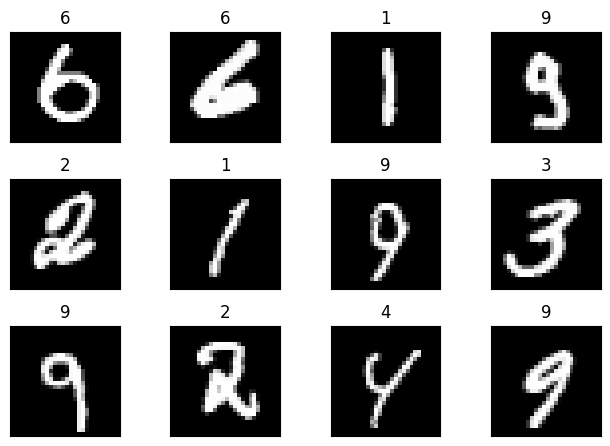

In [131]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [132]:
from tqdm import tqdm

train_losses = []
train_acc = []
test_losses = []
test_acc = []
analyzer = None

def train(model, device, train_loader, optimizer, scheduler, epoch):
    """
    Training function that tracks loss and accuracy
    """
    model.train()
    pbar = tqdm(train_loader)
    
    train_loss = 0
    correct = 0
    processed = 0
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calculate loss
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()

        scheduler.step()
        
        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        # Display current learning rate
        current_lr = scheduler.get_last_lr()[0]
        pbar.set_description(f'Epoch={epoch} LR={current_lr:.5f} Loss={loss.item():.4f} Batch_id={batch_idx}, Acc={100*correct/processed:.2f}')
    
    # Store epoch metrics
    train_losses.append(train_loss/len(train_loader))
    train_acc.append(100. * correct / len(train_loader.dataset))
    
    print(f'\nTrain Epoch: {epoch} Average Loss: {train_loss/len(train_loader):.4f}, Accuracy: {100. * correct/len(train_loader.dataset):.2f}%')


def test(model, device, test_loader, epoch=None):
    """
    Test/Validation function that tracks loss and accuracy
    """
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Capture failures
            analyzer.add_batch(data, target, output, batch_idx)

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    # Store test metrics
    test_losses.append(test_loss)
    test_acc.append(accuracy)
    
    if epoch:
        print(f'Test Epoch: {epoch} Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
        print(f'Failure Rate: {analyzer.get_failure_rate():.2f}%')
        print(f'Failures Captured: {len(analyzer.failures)}')
    else:
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    
    return test_loss, accuracy, analyzer




In [136]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use OneCycleLR scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.1,
    epochs=20,
    steps_per_epoch=len(train_loader)
)

criterion = nn.NLLLoss()

train_losses.clear()
train_acc.clear()
test_losses.clear()
test_acc.clear()

# For MNIST dataset
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Create analyzer if not provided
if analyzer is None:
    analyzer = FailureAnalyzer(class_names=class_names)
else:
    analyzer.reset()

epochs = 20
# Updated training loop

print (f"Batch size = {batch_size}")
for epoch in range(1, epochs+1):
    train(model, device, train_loader, optimizer, scheduler, epoch)
    test_loss, accuracy, analyzer = test(model, device, val_loader, epoch)  # Use validation instead of test

    # Show various failure visualizations
    
    # 1. Show 20 random failure cases
    #analyzer.show_failures(num_samples=8, sort_by='random')
    
    # 2. Show 10 worst failures (highest loss)
    #analyzer.show_worst_failures(num_samples=10)
    
    # 3. Show high-confidence failures (model was confident but wrong)
    #analyzer.show_high_confidence_failures(num_samples=10)
    
    # 4. Show confusion analysis
    #analyzer.show_confusion_analysis(top_k=10)
    
    # 5. Get failure summary
    #summary = analyzer.get_failure_summary()
    #print("Failure Summary:", summary)
    

Batch size = 128


Epoch=1 LR=0.01044 Loss=0.3581 Batch_id=390, Acc=79.97: 100%|██████████| 391/391 [00:06<00:00, 59.05it/s] 


Train Epoch: 1 Average Loss: 0.7267, Accuracy: 79.97%


Test Epoch: 1 Average loss: 0.1486, Accuracy: 9703/10000 (97.03%)

Failure Rate: 2.97%
Failures Captured: 297


Epoch=2 LR=0.02802 Loss=0.4630 Batch_id=390, Acc=88.02: 100%|██████████| 391/391 [00:02<00:00, 142.61it/s]


Train Epoch: 2 Average Loss: 0.3484, Accuracy: 88.02%


Test Epoch: 2 Average loss: 0.0973, Accuracy: 9761/10000 (97.61%)

Failure Rate: 2.68%
Failures Captured: 536


Epoch=3 LR=0.05203 Loss=0.4388 Batch_id=390, Acc=88.50: 100%|██████████| 391/391 [00:06<00:00, 59.66it/s] 


Train Epoch: 3 Average Loss: 0.3156, Accuracy: 88.50%


Test Epoch: 3 Average loss: 0.0605, Accuracy: 9861/10000 (98.61%)

Failure Rate: 2.25%
Failures Captured: 675


Epoch=4 LR=0.07604 Loss=0.2884 Batch_id=390, Acc=88.63: 100%|██████████| 391/391 [00:02<00:00, 138.51it/s]


Train Epoch: 4 Average Loss: 0.3038, Accuracy: 88.63%


Test Epoch: 4 Average loss: 0.0474, Accuracy: 9881/10000 (98.81%)

Failure Rate: 1.98%
Failures Captured: 794


Epoch=5 LR=0.09360 Loss=0.5776 Batch_id=390, Acc=89.01: 100%|██████████| 391/391 [00:06<00:00, 57.69it/s] 


Train Epoch: 5 Average Loss: 0.2908, Accuracy: 89.01%


Test Epoch: 5 Average loss: 0.0424, Accuracy: 9896/10000 (98.96%)

Failure Rate: 1.80%
Failures Captured: 898


Epoch=6 LR=0.10000 Loss=0.3041 Batch_id=390, Acc=89.10: 100%|██████████| 391/391 [00:05<00:00, 73.05it/s] 


Train Epoch: 6 Average Loss: 0.2855, Accuracy: 89.10%


Test Epoch: 6 Average loss: 0.0389, Accuracy: 9908/10000 (99.08%)

Failure Rate: 1.65%
Failures Captured: 990


Epoch=7 LR=0.09874 Loss=0.1803 Batch_id=390, Acc=89.05: 100%|██████████| 391/391 [00:06<00:00, 57.53it/s] 


Train Epoch: 7 Average Loss: 0.2848, Accuracy: 89.05%


Test Epoch: 7 Average loss: 0.0395, Accuracy: 9903/10000 (99.03%)

Failure Rate: 1.55%
Failures Captured: 1000


Epoch=8 LR=0.09504 Loss=0.3191 Batch_id=390, Acc=89.33: 100%|██████████| 391/391 [00:04<00:00, 86.78it/s] 


Train Epoch: 8 Average Loss: 0.2767, Accuracy: 89.33%


Test Epoch: 8 Average loss: 0.0345, Accuracy: 9917/10000 (99.17%)

Failure Rate: 1.46%
Failures Captured: 1000


Epoch=9 LR=0.08907 Loss=0.2797 Batch_id=390, Acc=89.42: 100%|██████████| 391/391 [00:06<00:00, 63.79it/s] 


Train Epoch: 9 Average Loss: 0.2732, Accuracy: 89.42%


Test Epoch: 9 Average loss: 0.0409, Accuracy: 9894/10000 (98.94%)

Failure Rate: 1.42%
Failures Captured: 1000


Epoch=10 LR=0.08115 Loss=0.3413 Batch_id=390, Acc=89.57: 100%|██████████| 391/391 [00:07<00:00, 50.43it/s] 


Train Epoch: 10 Average Loss: 0.2688, Accuracy: 89.57%


Test Epoch: 10 Average loss: 0.0336, Accuracy: 9913/10000 (99.13%)

Failure Rate: 1.36%
Failures Captured: 1000


Epoch=11 LR=0.07167 Loss=0.3086 Batch_id=390, Acc=89.72: 100%|██████████| 391/391 [00:06<00:00, 59.11it/s] 



Train Epoch: 11 Average Loss: 0.2653, Accuracy: 89.72%
Test Epoch: 11 Average loss: 0.0339, Accuracy: 9916/10000 (99.16%)

Failure Rate: 1.32%
Failures Captured: 1000


Epoch=12 LR=0.06110 Loss=0.2688 Batch_id=390, Acc=89.82: 100%|██████████| 391/391 [00:08<00:00, 47.90it/s]


Train Epoch: 12 Average Loss: 0.2620, Accuracy: 89.82%


Test Epoch: 12 Average loss: 0.0308, Accuracy: 9924/10000 (99.24%)

Failure Rate: 1.27%
Failures Captured: 1000


Epoch=13 LR=0.04997 Loss=0.2394 Batch_id=390, Acc=89.68: 100%|██████████| 391/391 [00:02<00:00, 138.23it/s]


Train Epoch: 13 Average Loss: 0.2641, Accuracy: 89.68%


Test Epoch: 13 Average loss: 0.0304, Accuracy: 9926/10000 (99.26%)

Failure Rate: 1.23%
Failures Captured: 1000


Epoch=14 LR=0.03885 Loss=0.4385 Batch_id=390, Acc=89.93: 100%|██████████| 391/391 [00:06<00:00, 65.06it/s] 


Train Epoch: 14 Average Loss: 0.2599, Accuracy: 89.93%


Test Epoch: 14 Average loss: 0.0274, Accuracy: 9926/10000 (99.26%)

Failure Rate: 1.19%
Failures Captured: 1000


Epoch=15 LR=0.02828 Loss=0.1757 Batch_id=390, Acc=89.86: 100%|██████████| 391/391 [00:04<00:00, 96.28it/s] 


Train Epoch: 15 Average Loss: 0.2617, Accuracy: 89.86%


Test Epoch: 15 Average loss: 0.0274, Accuracy: 9931/10000 (99.31%)

Failure Rate: 1.16%
Failures Captured: 1000


Epoch=16 LR=0.01880 Loss=0.2695 Batch_id=390, Acc=90.35: 100%|██████████| 391/391 [00:03<00:00, 127.76it/s]


Train Epoch: 16 Average Loss: 0.2492, Accuracy: 90.35%


Test Epoch: 16 Average loss: 0.0235, Accuracy: 9943/10000 (99.43%)

Failure Rate: 1.12%
Failures Captured: 1000


Epoch=17 LR=0.01089 Loss=0.3018 Batch_id=390, Acc=90.12: 100%|██████████| 391/391 [00:06<00:00, 59.51it/s] 


Train Epoch: 17 Average Loss: 0.2537, Accuracy: 90.12%


Test Epoch: 17 Average loss: 0.0244, Accuracy: 9944/10000 (99.44%)

Failure Rate: 1.09%
Failures Captured: 1000


Epoch=18 LR=0.00494 Loss=0.4662 Batch_id=390, Acc=90.12: 100%|██████████| 391/391 [00:05<00:00, 75.15it/s] 


Train Epoch: 18 Average Loss: 0.2533, Accuracy: 90.12%


Test Epoch: 18 Average loss: 0.0226, Accuracy: 9943/10000 (99.43%)

Failure Rate: 1.06%
Failures Captured: 1000


Epoch=19 LR=0.00125 Loss=0.3766 Batch_id=390, Acc=90.41: 100%|██████████| 391/391 [00:06<00:00, 56.98it/s] 


Train Epoch: 19 Average Loss: 0.2460, Accuracy: 90.41%


Test Epoch: 19 Average loss: 0.0232, Accuracy: 9946/10000 (99.46%)

Failure Rate: 1.03%
Failures Captured: 1000


Epoch=20 LR=0.00000 Loss=0.1145 Batch_id=390, Acc=90.08: 100%|██████████| 391/391 [00:05<00:00, 70.29it/s] 


Train Epoch: 20 Average Loss: 0.2516, Accuracy: 90.08%


Test Epoch: 20 Average loss: 0.0231, Accuracy: 9950/10000 (99.50%)

Failure Rate: 1.01%
Failures Captured: 1000


Text(0.5, 1.0, 'Test Accuracy')

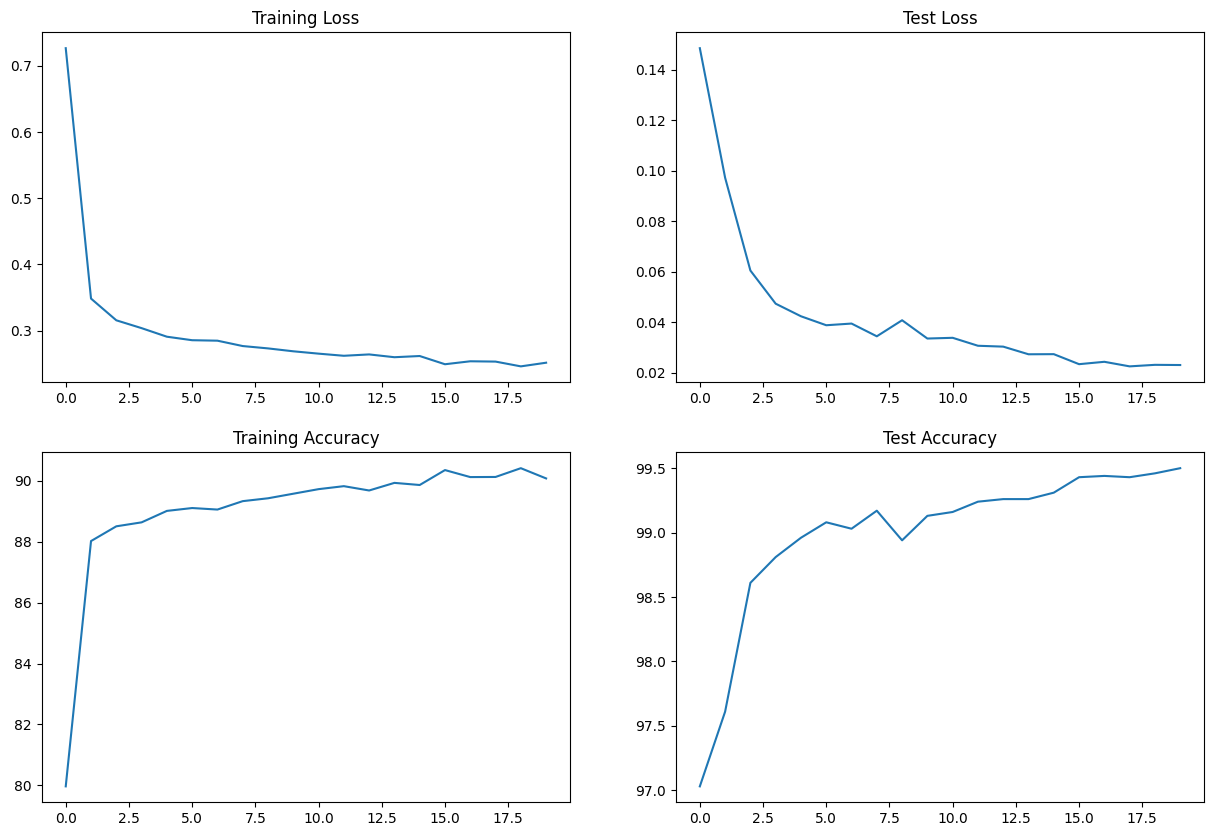

In [137]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")